          Kidney L   Kidney R      Liver      Aorta  Aorta wall  Ventricle  \
Subject                                                                      
S00732   13.934749  15.373420  48.586120   8.438181    6.279013  10.136120   
S00780   15.764618  17.049543  39.461339  12.240385    6.539955  12.453402   
S00786   29.094146  32.286983  72.588950  25.126943   18.536255  28.128147   
S00793   19.961651  23.430576  81.249394  13.881462    9.048400  16.442829   
S00796   10.497522  12.199778  32.438249   8.229330    4.142836   9.603170   
S00801   16.255900  21.021113  63.113142   7.672023    6.094815  13.627875   
S00810   14.533433  15.701356  45.511589  12.518356    6.168674  11.521946   
S00822   10.317812  10.689677  33.442865   8.309496    5.145480   9.356992   
S00828    9.294233  10.200302  29.119319   5.802032    4.658956   6.947735   
S00874   11.172826  12.717298  35.384780  11.859475    6.475960  10.070755   
S00919   17.250096  20.490495  74.134277  14.487781    5.573718 

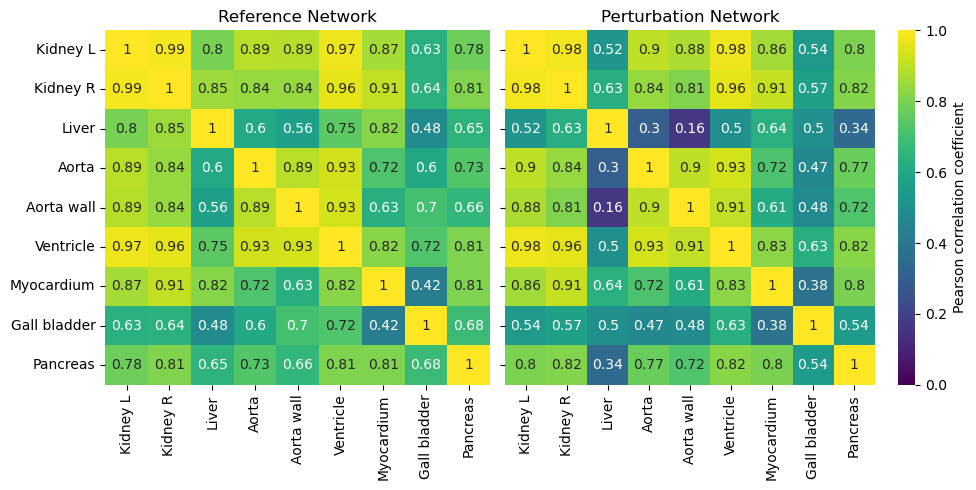

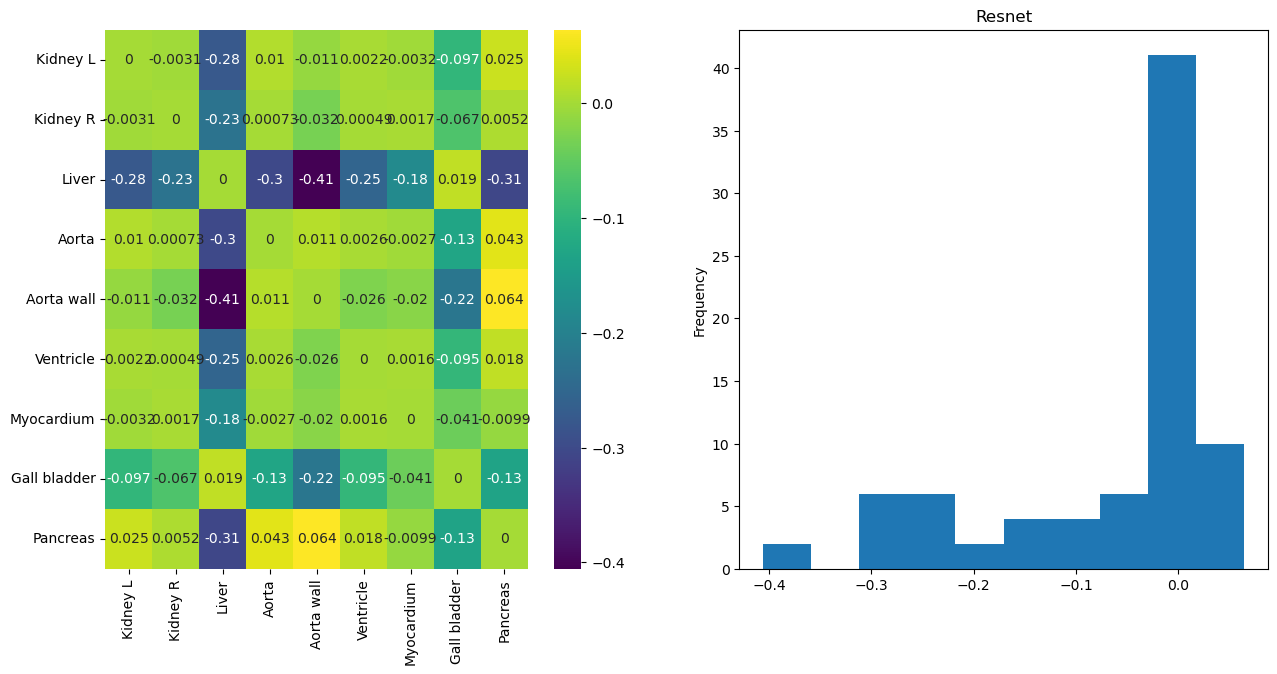

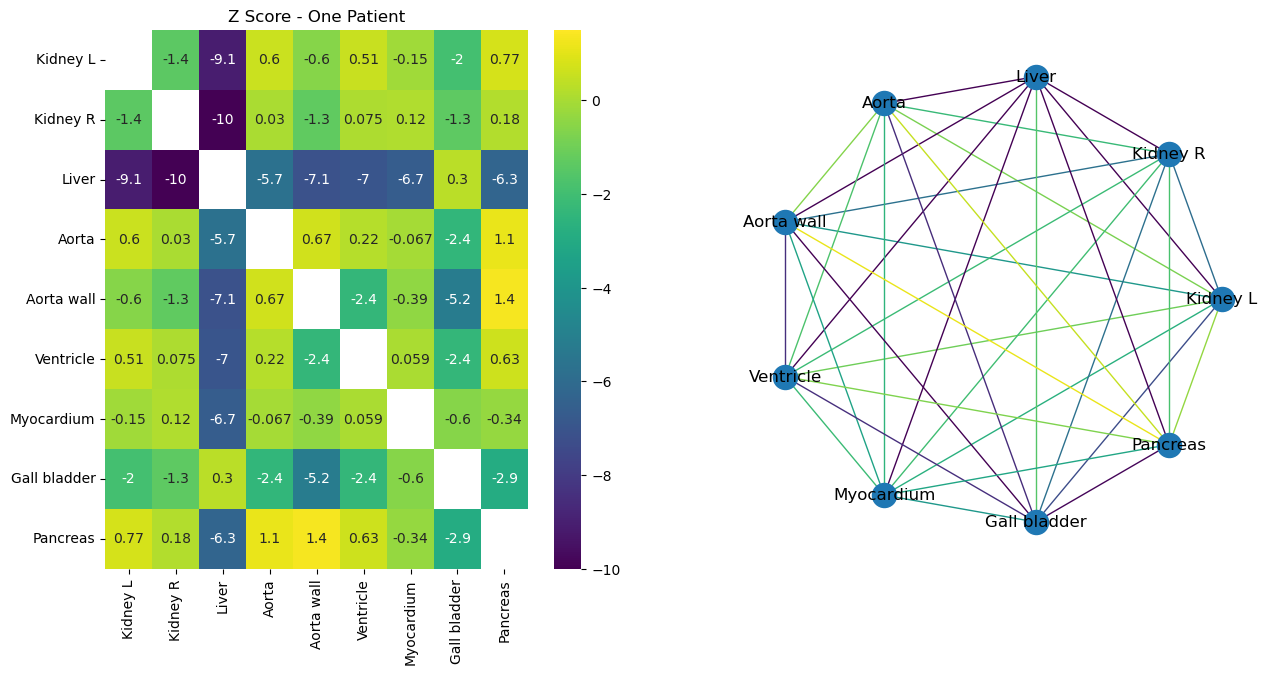

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from netgraph import Graph

#color palette choice for all graphing
palette='viridis'

#read in file, create dataframe with subjects on y, regions on x
filename = 'IsotoPK_data_linearinterpolated_static.csv'
df = pd.read_csv(filename, sep=',', usecols=['Subject', 'Kidney L', 'Kidney R', 'Liver', 'Aorta', 'Aorta wall', 'Ventricle', 'Myocardium', 
                                      'Gall bladder', 'Pancreas'], index_col=['Subject'], header=0)
#df = df.transpose() swaps to subjects on x, regions on y

#get one dataframe of control subjects only
ctrlsubs = ['S00732', 'S00780', 'S00786', 'S00793', 'S00796', 'S00801', 'S00810', 'S00822', 'S00828', 'S00874', 'S00919', 'S00933',
                   'S00956']
rifsubs = ['S00712', 'S00724', 'S00733', 'S00781', 'S00794', 'S00802', 'S00811', 'S00877', 'S00880']
ctrl = df.transpose()[ctrlsubs].copy().transpose()

print(ctrl)

#create the refNET with PCC between each region pair, subjects are the x-axis and SUV for a given region is y-axis
#paper uses partial PCC with covariates of age and gender, i will just use PCC for now 
#(Identifying the individual metabolic abnormities from a systemic perspective using whole-body PET imaging by Tao Sun et al)
refnet = ctrl.corr(method='pearson')
refnet = refnet.transpose()

#create the plot with two subplots, setting figure size and gridspec ratio (figures end up diff sizes when cbar=false for one)
fig, ax = plt.subplots(ncols=2, figsize=(10,5),sharey=True, gridspec_kw={'width_ratios': [1, 1.2]})

#create the heatmap to represent the correlation network of the control subjects (refNET)
snsctrl = sns.heatmap(refnet, annot=True, vmax=1.0, vmin=0.0, cbar_kws={'label': 'Pearson correlation coefficient'}, cbar=False, ax=ax[0],
                     cmap=palette)
ax[0].set_title('Reference Network')

#create the perturbation network by adding one rif subject to the ctrl cohort refNET -> ptbNET
ptb = df.transpose()[ctrlsubs].copy()
ptb = ptb.assign(rifsub=df.transpose()[rifsubs[0]])
ptbnet = ptb.transpose().corr(method='pearson').transpose()

#create the heatmap that represents the ptbNET
snsptb = sns.heatmap(ptbnet, annot=True, vmax=1.0, vmin=0.0, cbar_kws={'label': 'Pearson correlation coefficient'}, ax=ax[1], 
                     cmap=palette)
ax[1].set_title('Perturbation Network')

#create the resNET=ptbNET-refNET
resnet = ptbnet-refnet
#set threshold of 30% to remove weak residual correlations arising after sub. arising possibly from noise
# thresh = 0.3*max(resnet.stack().where(resnet.stack()>0).max(), abs(resnet.stack().where(resnet.stack()<0).min()))
# print(thresh)
# for col in resnet.columns:
#     resnet.loc[((resnet[col]>0)&(resnet[col]<thresh)) | ((resnet[col]<0)&(resnet[col]>(-thresh))), col] = 0

#plot with minimal white space
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

snsres = sns.heatmap(resnet, annot=True, cmap=palette, ax=ax[0])

resnet.stack().plot.hist(ax=ax[1])
plt.title('Resnet')
plt.show()

#create the zscore matrix - requires large n??
# zscore = resnet/((1-refnet**2)/(len(ctrl.columns)-1))
# #print(zscore)
# snszscore = sns.heatmap(zscore, annot=True)

#create the zscore plot with two subplots, setting figure size
fig, ax = plt.subplots(ncols=2, figsize=(15,7))

#create zscore matrix without relying on large n
#zscore = (resnet-resnet.stack().mean())/resnet.stack().std()
#zscore = (resnet-resnet.mean())/resnet.std()
zscore = resnet/((1-refnet**2)/(len(ctrlsubs)-1))
snszscore = sns.heatmap(zscore, annot=True, vmin=-10, vmax=1.5, cmap=palette, ax=ax[0])
ax[0].set_title('Z Score - One Patient')

#save to csv
zscore.to_csv('z_score.csv')

#networkx
G = nx.from_pandas_adjacency(zscore, create_using=nx.Graph)
G.remove_edges_from(nx.selfloop_edges(G))
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

max=zscore.stack().max()
nx.draw_circular(G, edge_color=weights, edge_cmap=plt.get_cmap(palette), edge_vmin=-3, edge_vmax=1.5, with_labels=True, ax=ax[1])
#plt.colorbar(plt.cm.ScalarMappable(cmap=plt.get_cmap(palette), norm=plt.Normalize(vmin=-3, vmax=1.5)), ax=plt.gca())

plt.show()

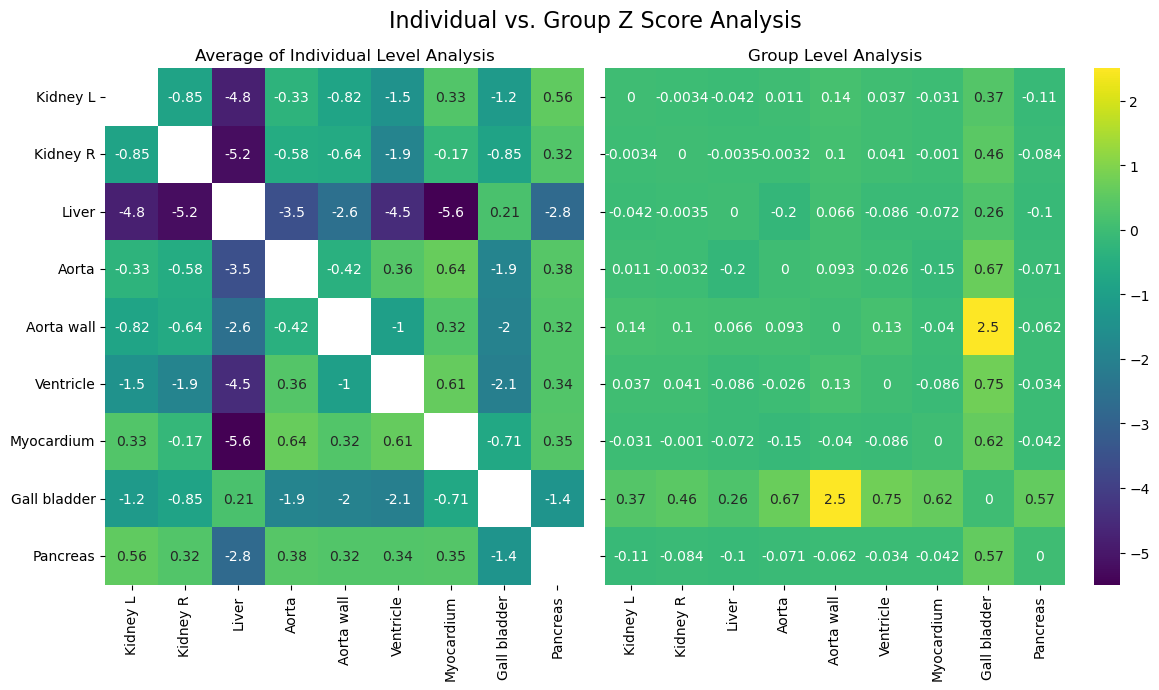

Kidney L       -0.042138
Kidney R        0.044509
Liver           0.673876
Aorta          -0.190313
Aorta wall     -0.478556
Ventricle      -0.190307
Myocardium     -0.030650
Gall bladder   -0.548630
Pancreas       -0.337811
dtype: float64


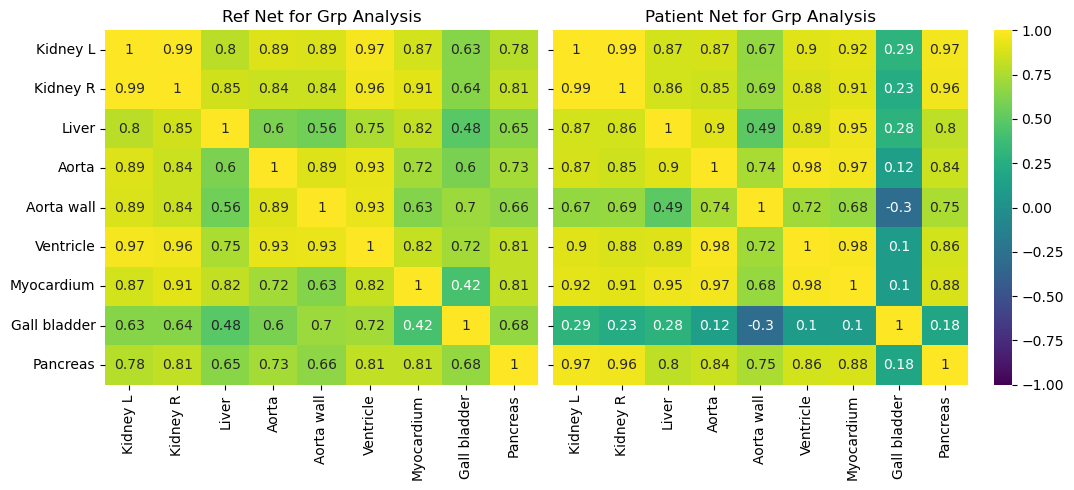

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(12,7),sharey=True, gridspec_kw={'width_ratios': [1, 1.2]})
fig.suptitle('Individual vs. Group Z Score Analysis', fontsize=16)

#individual-level analysis
zscore_list = []
resnet_list = []
for subject in rifsubs:
    ptb = df.transpose()[ctrlsubs].copy()
    ptb = ptb.assign(rifsub=df.transpose()[subject])
    ptbnet = ptb.transpose().corr(method='pearson').transpose()
    resnet = ptbnet-refnet
    resnet_list.append(resnet)
    zscore = resnet/((1-refnet**2)/(len(ctrlsubs)-1))                #changing between this method and the one below shifts the z-score hist
    #zscore = (resnet-resnet.stack().mean())/resnet.stack().std()
    zscore_list.append(zscore)
avgzscore = sum(zscore_list)/len(zscore_list)
snszscore = sns.heatmap(avgzscore, annot=True, vmin=-5.5, vmax=2.5, cmap=palette, cbar=False, ax=ax[0])
ax[0].set_title('Average of Individual Level Analysis')

#group-level analysis
rif = df.transpose()[rifsubs].copy().transpose()
patnet = rif.corr(method='pearson')
patnet = patnet.transpose()
# grpptbnet = rif.corr(method='pearson')
# grpptbnet = grpptbnet.transpose()
# grpresnet = grpptbnet-refnet
# grpzscore = (grpresnet-grpresnet.stack().mean())/grpresnet.stack().std()
# snsgrpzscore = sns.heatmap(grpzscore, annot=True, vmin=-4, vmax=1.5, cmap=palette, ax=ax[1])
diffnet = (refnet-patnet)/(refnet+patnet)
snsgrp = sns.heatmap(diffnet, annot=True, vmin=-5.5, vmax=2.5, cmap=palette, ax=ax[1])
ax[1].set_title('Group Level Analysis')

fig.tight_layout()
plt.show()

compare = avgzscore.corrwith(diffnet, method='pearson')
print(compare)

fig, ax = plt.subplots(ncols=2, figsize=(11,5),sharey=True, gridspec_kw={'width_ratios': [1, 1.2]})
snsgrp = sns.heatmap(refnet, annot=True, vmin=-1, vmax=1, cmap=palette, cbar=False, ax=ax[0])
ax[0].set_title('Ref Net for Grp Analysis')
snsgrp = sns.heatmap(patnet, annot=True, vmin=-1, vmax=1, cmap=palette, ax=ax[1])
ax[1].set_title('Patient Net for Grp Analysis')
fig.tight_layout()
plt.show()

n=729


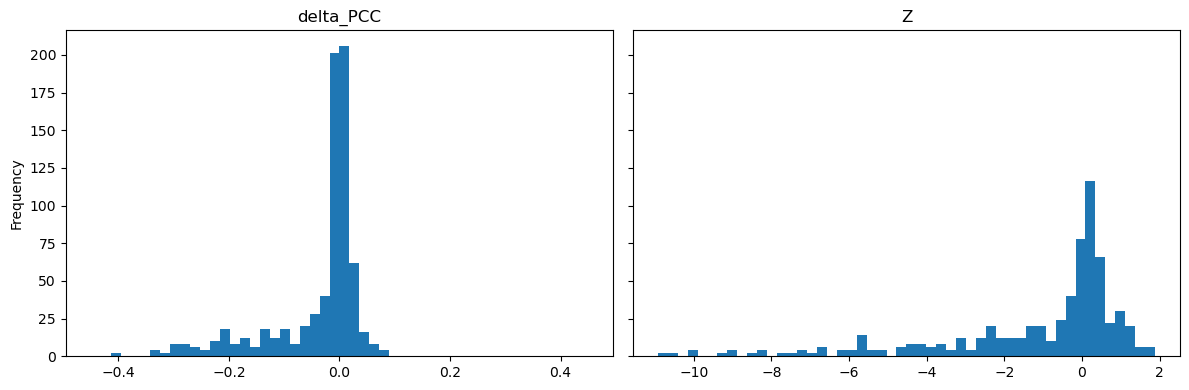

Text(0.5, 1.0, 'Z - all')

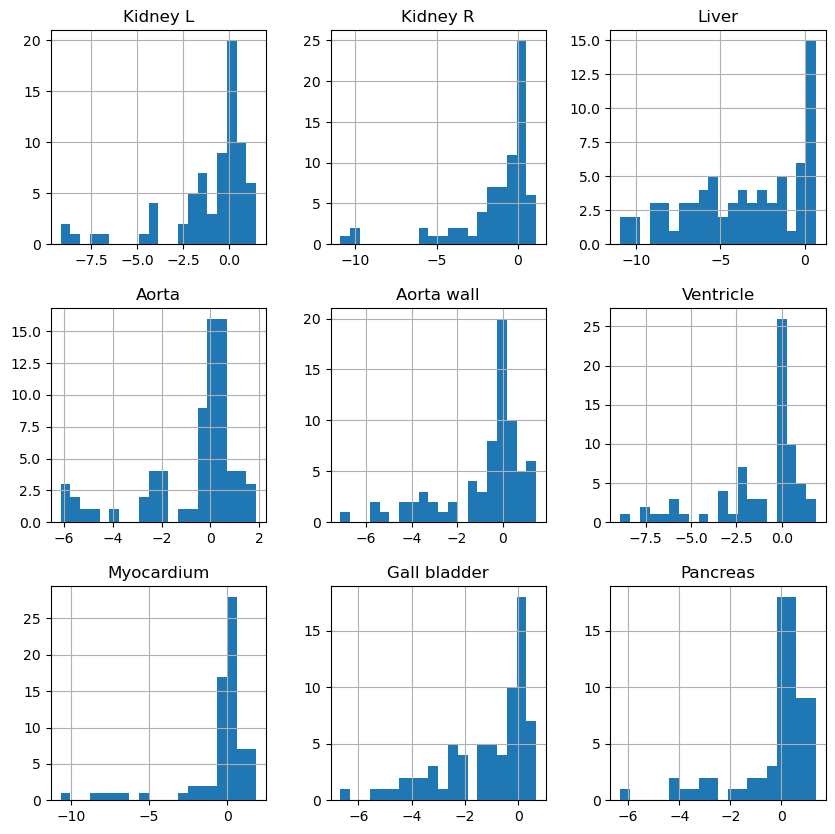

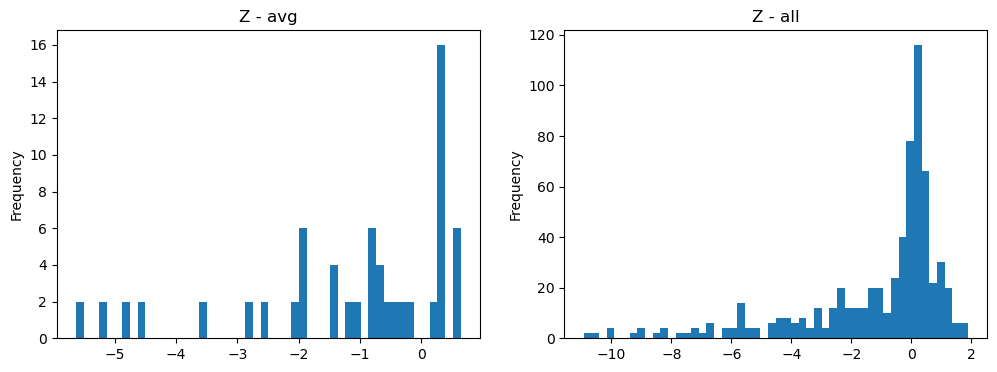

In [8]:
#histograms
fig, ax = plt.subplots(ncols=2, figsize=(12,4),sharey=True)
rescomb = pd.concat(resnet_list, ignore_index=True)
print("n="+str(rescomb.stack().count()))
rescomb.stack().plot.hist(bins=50, range=[-0.45, 0.45], ax=ax[0])
ax[0].set_title('delta_PCC')
zcomb = pd.concat(zscore_list, ignore_index=True)
zcomb.stack().plot.hist(bins=50, ax=ax[1])
ax[1].set_title('Z')

fig.tight_layout()
plt.show()

fig, axis = plt.subplots(3, 3, figsize=(10,10))
plt.title('Z - all')
zcomb.hist(bins=20, ax=axis)

fig, ax = plt.subplots(ncols=2, figsize=(12,4))
avgzscore.stack().plot.hist(bins=50, ax=ax[0])
ax[0].set_title('Z - avg')
zcomb.stack().plot.hist(bins=50, ax=ax[1])
ax[1].set_title('Z - all')

# fig, axis = plt.subplots(3, 3, figsize=(10,10))
# plt.title('Z - avg')
# avgzscore.hist(bins=20, range=[-3.25,3.25], ax=axis)

from -1.77 to 0.84


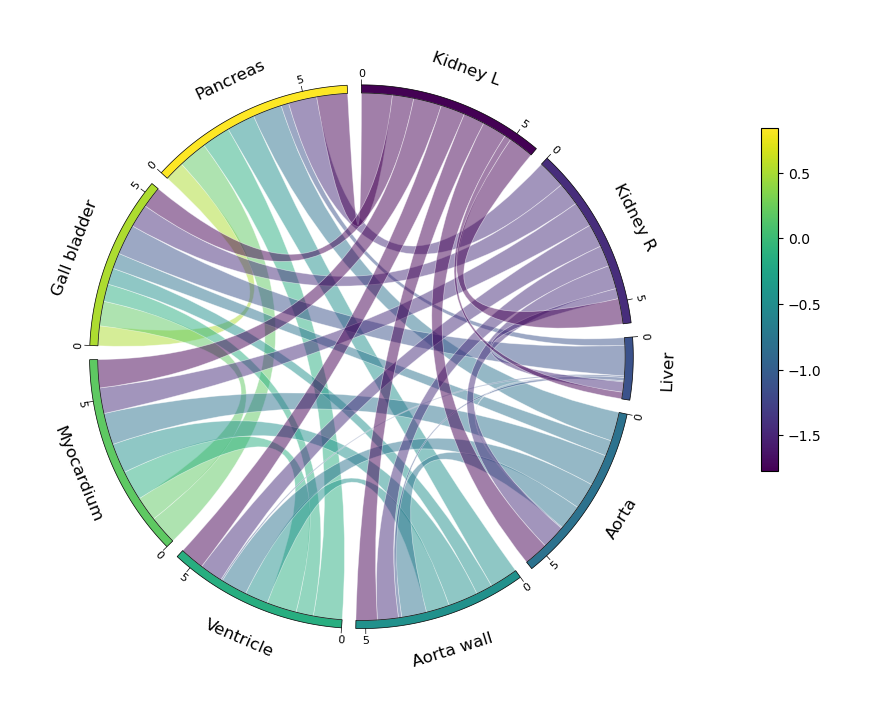

In [72]:
from pycirclize import Circos
from pycirclize.parser import Matrix

adjmat = nx.to_pandas_adjacency(G)
edgelist = nx.to_pandas_edgelist(G)
min=edgelist['weight'].min()
max=edgelist['weight'].max()
print('from {0:.2f} to {1:.2f}'.format(min, max))
edgelist['newweight'] = edgelist['weight']
edgelist['newweight'] += edgelist['newweight'].min()
edgelist['newweight'] -= edgelist['newweight'].min()
edgelist['newweight'] /= (edgelist['newweight'].max() - edgelist['newweight'].min())
#print(edgelist)
edgelist['weight'] = edgelist['newweight']
edgelist.drop(columns = ['newweight'])

matrix = Matrix.parse_fromto_table(edgelist)

circos = Circos.initialize_from_matrix(
    matrix,
    space=3,
    cmap="viridis",
    ticks_interval=5,
    label_kws=dict(size=12, r=110),
    link_kws=dict(ec="white", lw=0.5),
)

circos.colorbar(cmap='viridis', vmin=min, vmax=max, bounds=(1.2, 0.3, 0.03, 0.6))

fig = circos.plotfig()

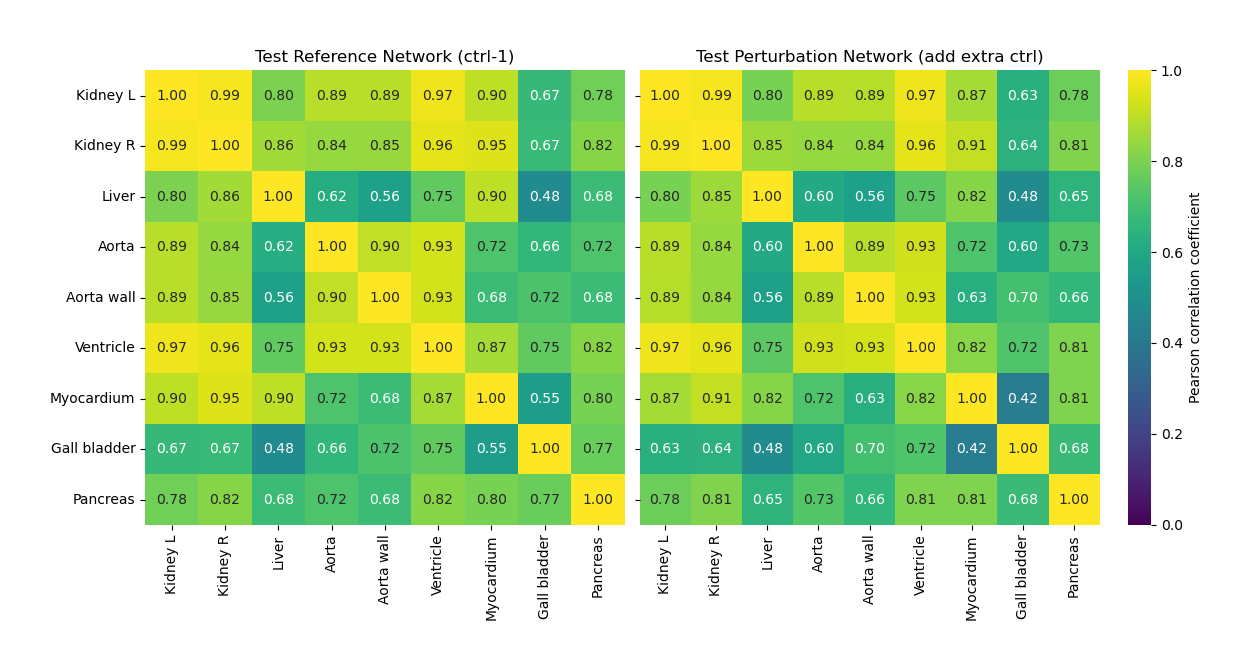

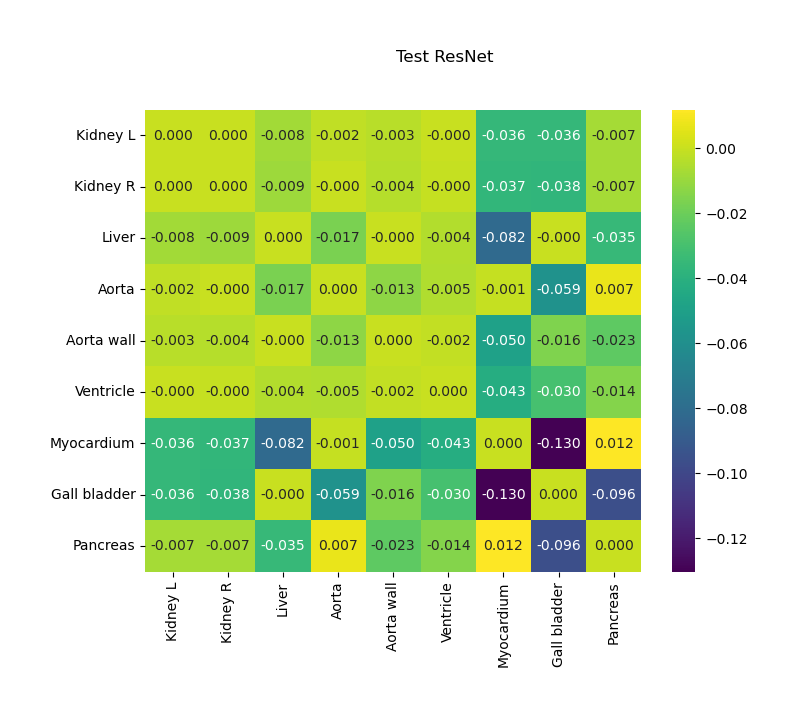

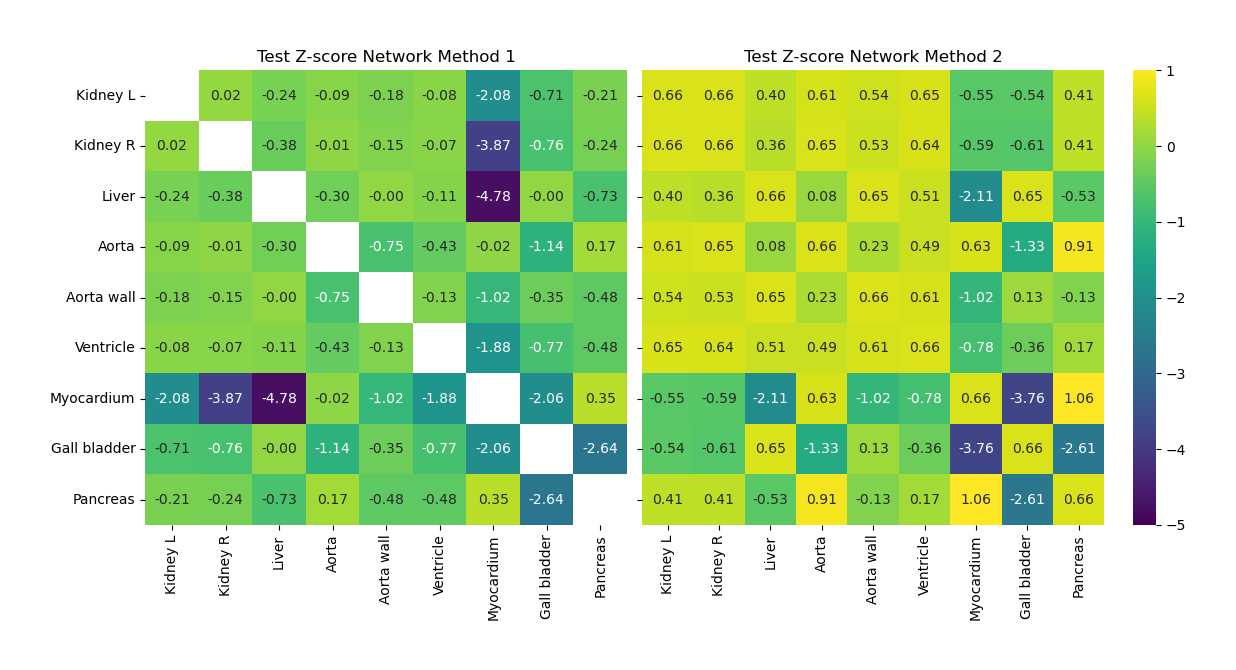

In [60]:
#test a control
ctrlsubs_test = ['S00732', 'S00780', 'S00786', 'S00793', 'S00796', 'S00801', 'S00810', 'S00822', 'S00828', 'S00874', 'S00919', 'S00933']
testsub = 'S00956'
ctrl_test = df.transpose()[ctrlsubs_test].copy().transpose()
refnet_test = ctrl_test.corr(method='pearson')
refnet_test = refnet_test.transpose()
fig, ax = plt.subplots(ncols=2, figsize=(12,6),sharey=True, gridspec_kw={'width_ratios': [1, 1.2]})
snsctrl_test = sns.heatmap(refnet_test, annot=True, vmax=1.0, vmin=0.0, cbar_kws={'label': 'Pearson correlation coefficient'}, cbar=False,
                     ax=ax[0], cmap=palette, fmt='0.2f')
ax[0].set_title('Test Reference Network (ctrl-1)')
ptb_test = df.transpose()[ctrlsubs_test].copy()
ptb_test = ptb_test.assign(testsub=df.transpose()[testsub])
ptbnet_test = ptb_test.transpose().corr(method='pearson').transpose()
snsptb_test = sns.heatmap(ptbnet_test, annot=True, vmax=1.0, vmin=0.0, cbar_kws={'label': 'Pearson correlation coefficient'}, ax=ax[1], 
                     cmap=palette, fmt='0.2f')
ax[1].set_title('Test Perturbation Network (add extra ctrl)')
fig.tight_layout()
plt.show()
fig = plt.figure(figsize=(8,6))
resnet_test = ptbnet_test-refnet_test
snsres_test = sns.heatmap(resnet_test, annot=True, fmt='0.3f', cmap=palette)
fig.suptitle('Test ResNet')
plt.show()
fig, ax = plt.subplots(ncols=2, figsize=(12,6),sharey=True, gridspec_kw={'width_ratios': [1, 1.2]})
zscore_test = resnet_test/((1-refnet_test**2)/(len(ctrlsubs_test)-1))
snszscore_test = sns.heatmap(zscore_test, annot=True, vmin=-5, vmax=1, cmap=palette, ax=ax[0], cbar=False, fmt='0.2f')
ax[0].set_title('Test Z-score Network Method 1')
zscore_test2 = (resnet_test-resnet_test.stack().mean())/resnet_test.stack().std()
snszscore_test2 = sns.heatmap(zscore_test2, annot=True, vmin=-5, vmax=1, cmap=palette, ax=ax[1], fmt='0.2f')
ax[1].set_title('Test Z-score Network Method 2')
fig.tight_layout()
plt.show()

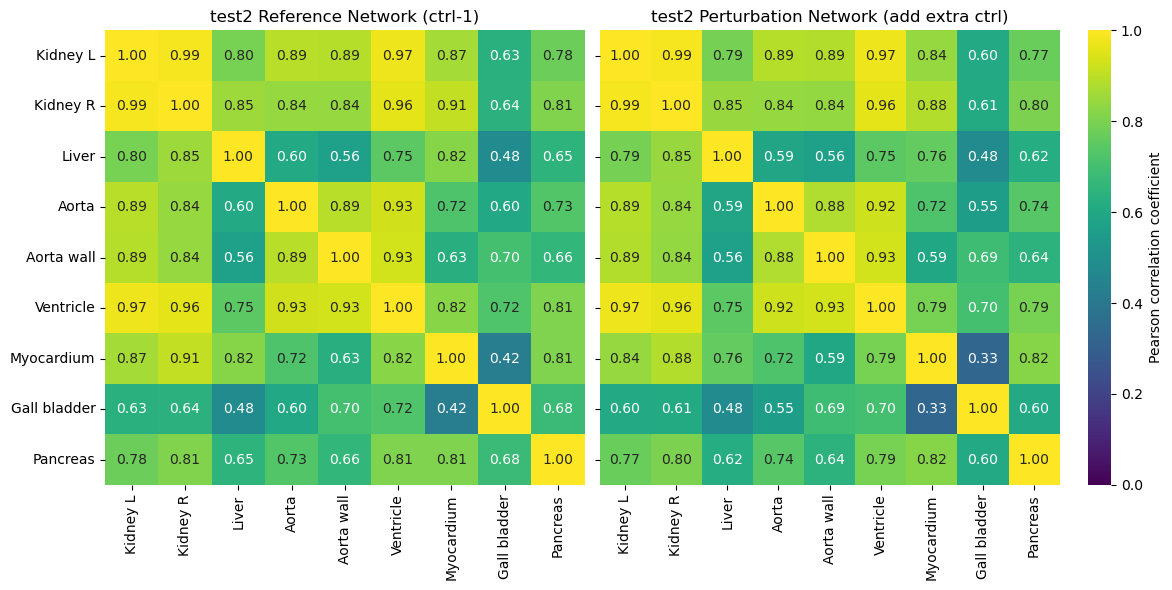

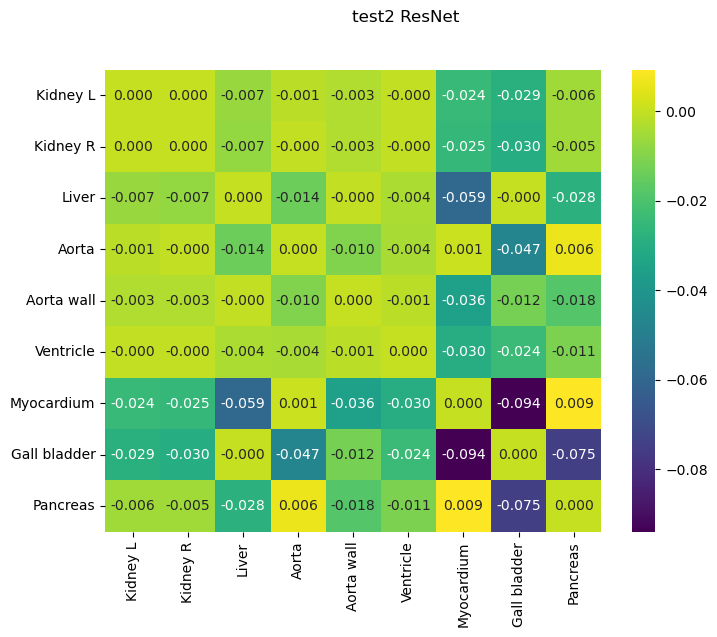

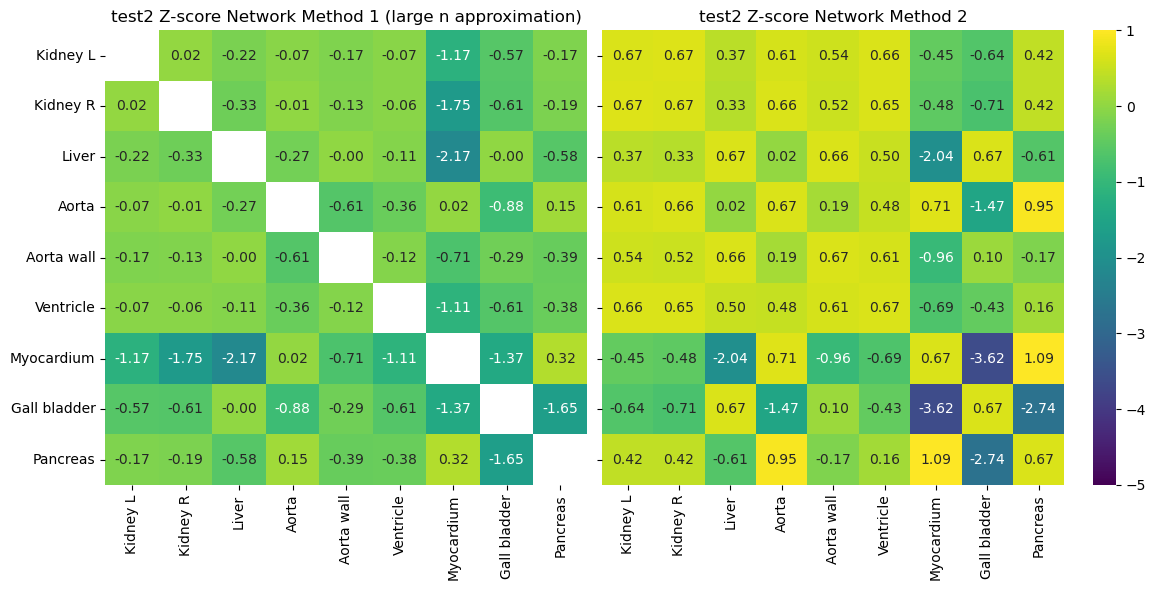

In [2]:
#test2 a control without removing it from ctrlsubs
ctrlsubs_test2 = ['S00732', 'S00780', 'S00786', 'S00793', 'S00796', 'S00801', 'S00810', 'S00822', 'S00828', 'S00874', 'S00919', 'S00933',
                'S00956']
test2sub = 'S00956'
ctrl_test2 = df.transpose()[ctrlsubs_test2].copy().transpose()
refnet_test2 = ctrl_test2.corr(method='pearson')
refnet_test2 = refnet_test2.transpose()
fig, ax = plt.subplots(ncols=2, figsize=(12,6),sharey=True, gridspec_kw={'width_ratios': [1, 1.2]})
snsctrl_test2 = sns.heatmap(refnet_test2, annot=True, vmax=1.0, vmin=0.0, cbar_kws={'label': 'Pearson correlation coefficient'}, cbar=False,
                     ax=ax[0], cmap=palette, fmt='0.2f')
ax[0].set_title('test2 Reference Network (ctrl-1)')
ptb_test2 = df.transpose()[ctrlsubs_test2].copy()
ptb_test2 = ptb_test2.assign(test2sub=df.transpose()[test2sub])
ptbnet_test2 = ptb_test2.transpose().corr(method='pearson').transpose()
snsptb_test2 = sns.heatmap(ptbnet_test2, annot=True, vmax=1.0, vmin=0.0, cbar_kws={'label': 'Pearson correlation coefficient'}, ax=ax[1], 
                     cmap=palette, fmt='0.2f')
ax[1].set_title('test2 Perturbation Network (add extra ctrl)')
fig.tight_layout()
plt.show()
fig = plt.figure(figsize=(8,6))
resnet_test2 = ptbnet_test2-refnet_test2
snsres_test2 = sns.heatmap(resnet_test2, annot=True, fmt='0.3f', cmap=palette)
fig.suptitle('test2 ResNet')
plt.show()
fig, ax = plt.subplots(ncols=2, figsize=(12,6),sharey=True, gridspec_kw={'width_ratios': [1, 1.2]})
zscore_test2 = resnet_test2/((1-refnet_test2**2)/(len(ctrlsubs_test2)-1))
snszscore_test2 = sns.heatmap(zscore_test2, annot=True, vmin=-5, vmax=1, cmap=palette, ax=ax[0], cbar=False, fmt='0.2f')
ax[0].set_title('test2 Z-score Network Method 1 (large n approximation)')
zscore_test22 = (resnet_test2-resnet_test2.stack().mean())/resnet_test2.stack().std()
snszscore_test22 = sns.heatmap(zscore_test22, annot=True, vmin=-5, vmax=1, cmap=palette, ax=ax[1], fmt='0.2f')
ax[1].set_title('test2 Z-score Network Method 2')
fig.tight_layout()
plt.show()

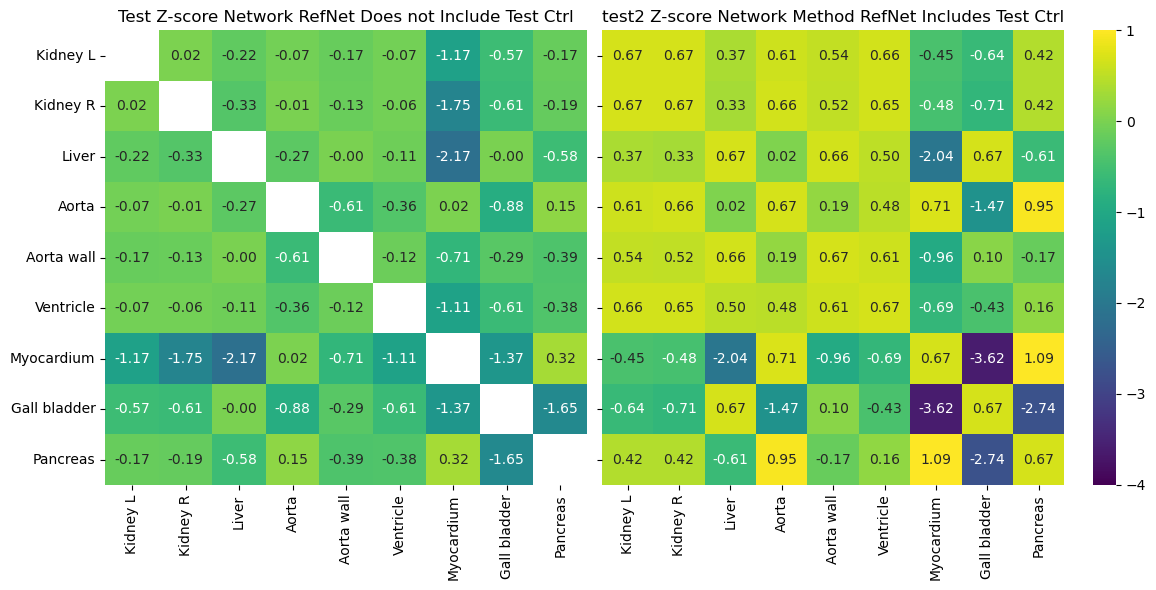

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6),sharey=True, gridspec_kw={'width_ratios': [1, 1.2]})

snszscore_test2 = sns.heatmap(zscore_test2, annot=True, vmin=-4, vmax=1, cmap=palette, ax=ax[0], fmt='0.2f', cbar=False)
ax[0].set_title('Test Z-score Network RefNet Does not Include Test Ctrl')

snszscore_test22 = sns.heatmap(zscore_test22, annot=True, vmin=-4, vmax=1, cmap=palette, ax=ax[1], fmt='0.2f')
ax[1].set_title('test2 Z-score Network Method RefNet Includes Test Ctrl')

fig.tight_layout()
plt.show()

/Users/abbyhellman/anaconda3/lib/python3.8/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


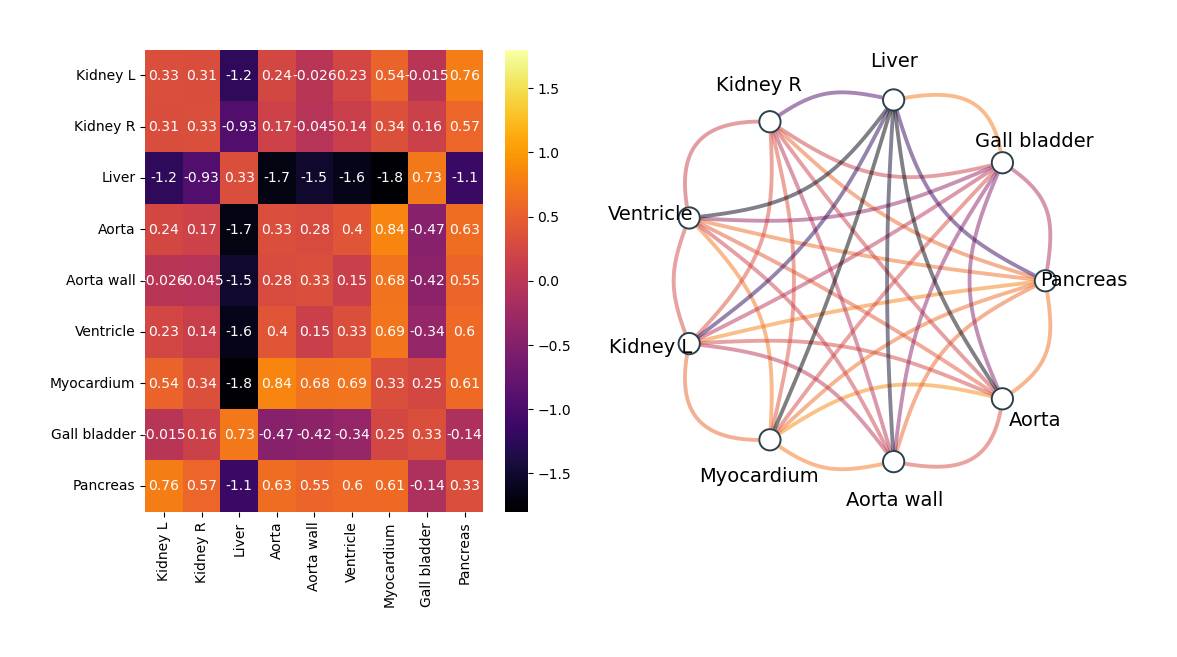

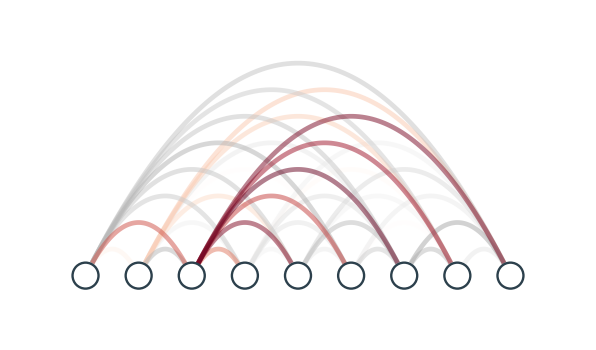

In [52]:
from netgraph import ArcDiagram

G = nx.from_pandas_adjacency(avgzscore, create_using=nx.Graph)
G.remove_edges_from(nx.selfloop_edges(G))
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

#max=zscore.stack().max()
#nx.draw_circular(G, edge_color=weights, edge_cmap=plt.get_cmap(palette), edge_vmin=-3, edge_vmax=1.5, with_labels=True)

fig, ax = plt.subplots(ncols=2, figsize=(12,6), gridspec_kw={'width_ratios': [1, 1]})
snszscore = sns.heatmap(avgzscore, annot=True, vmin=-1.8, vmax=1.8, cmap='inferno', ax=ax[0])
Graph(G, node_labels=True, node_label_fontdict=dict(size=14), node_label_offset=0.1, edge_cmap='inferno', node_layout='circular', edge_layout='curved', ax=ax[1])
plt.show()

ArcDiagram(G)

-0.4591038669662131 0.31740948204208513


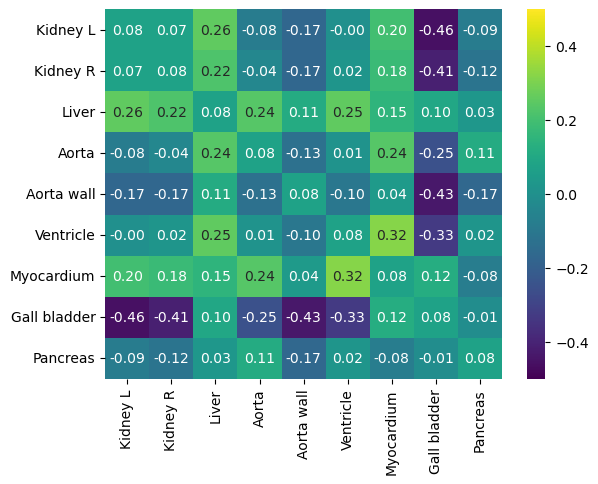

In [6]:
#test every control without removing it from ctrlsubs
ctrlsubs_alltest = ['S00732', 'S00780', 'S00786', 'S00793', 'S00796', 'S00801', 'S00810', 'S00822', 'S00828', 'S00874', 'S00919', 'S00933',
                'S00956']
ctrl_alltest = df.transpose()[ctrlsubs_alltest].copy().transpose()
refnet_alltest = ctrl_alltest.corr(method='pearson')
refnet_alltest = refnet_alltest.transpose()
zscore_test_list = []

for i in range(len(ctrlsubs_alltest)-1):
    testsub = ctrlsubs_alltest[i]
    ptb_alltest = df.transpose()[ctrlsubs_alltest].copy()
    ptb_alltest = ptb_alltest.assign(testsub=df.transpose()[testsub])
    ptbnet_alltest = ptb_alltest.transpose().corr(method='pearson').transpose()
    resnet_alltest = ptbnet_alltest-refnet_alltest
    zscore_alltest = (resnet_alltest-resnet_alltest.stack().mean())/resnet_alltest.stack().std()
    zscore_test_list.append(zscore_alltest)

avgzscore_test = sum(zscore_test_list)/len(zscore_test_list)
print(avgzscore_test.stack().min(), avgzscore_test.stack().max())
snszscore_test = sns.heatmap(avgzscore_test, annot=True, vmin=-0.5, vmax=0.5, cmap=palette, fmt='0.2f')

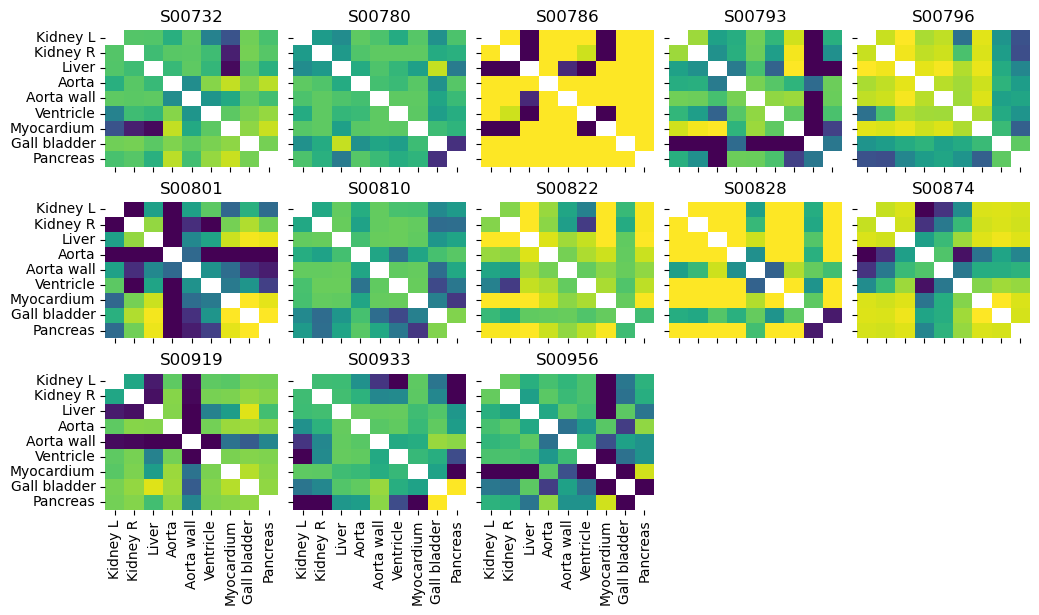

range = [-10, 10]
min =  -0.7288097899411579 , max =  0.3960518523173482


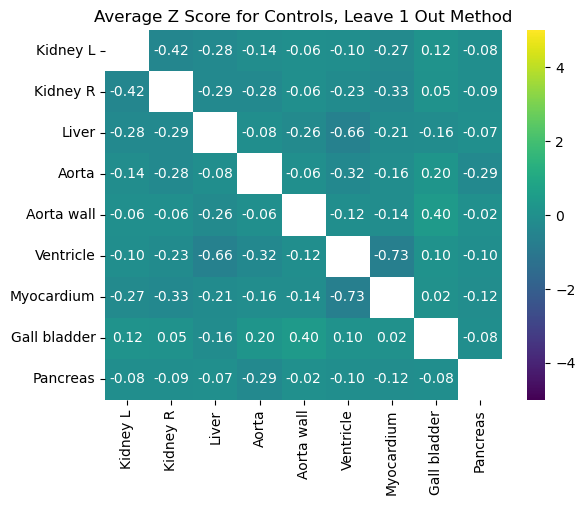

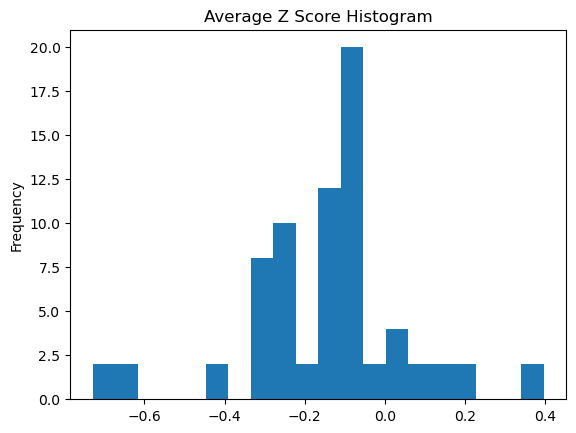

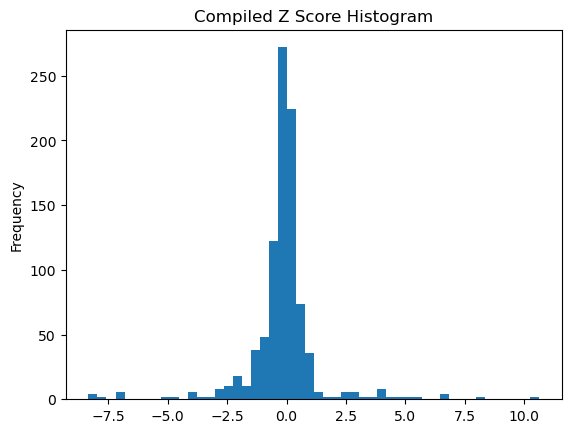

array([[<Axes: title={'center': 'Kidney L'}>,
        <Axes: title={'center': 'Kidney R'}>,
        <Axes: title={'center': 'Liver'}>],
       [<Axes: title={'center': 'Aorta'}>,
        <Axes: title={'center': 'Aorta wall'}>,
        <Axes: title={'center': 'Ventricle'}>],
       [<Axes: title={'center': 'Myocardium'}>,
        <Axes: title={'center': 'Gall bladder'}>,
        <Axes: title={'center': 'Pancreas'}>]], dtype=object)

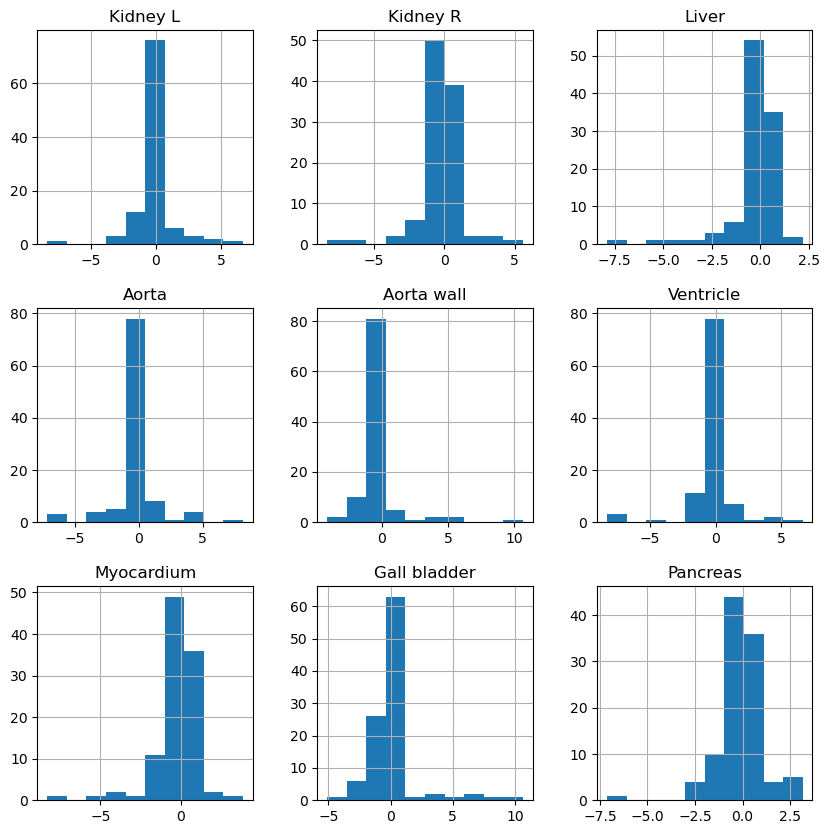

In [20]:
#Leave one out approach for control subjects

fig, axes = plt.subplots(3, 5, sharey=True, sharex=True, figsize=(10.5,6.25))
j = 0

# resnet_list = []
zscore_list = []
for i in ctrlsubs:
    testsub = i
    ctrlsubs_l1o = ctrlsubs.copy()
    ctrlsubs_l1o.remove(testsub)
    ctrl_l1o = df.transpose()[ctrlsubs_l1o].copy().transpose()
    refnet_l1o = ctrl_l1o.corr(method='pearson')
    refnet_l1o = refnet_l1o.transpose()
    ptb_l1o = df.transpose()[ctrlsubs_l1o].copy()
    ptb_l1o = ptb_l1o.assign(testsubdf=df.transpose()[testsub])
    ptbnet_l1o = ptb_l1o.transpose().corr(method='pearson').transpose()
    resnet_l1o = ptbnet_l1o-refnet_l1o
    # resnet_list.append(resnet_l1o)
    zscore_l1o = resnet_l1o/((1-refnet_l1o**2)/(len(ctrlsubs_l1o)-1))
    # # Method to plot each individual z score map
    # snszscore_indiv = sns.heatmap(zscore_l1o, annot=True, vmin=-4, vmax=2, cmap=palette, fmt='0.2f')
    # plt.title(testsub)
    # plt.show()
    # Method to plot each individual z score map in a grid
    snszscore_indiv = sns.heatmap(zscore_l1o, vmin=-1.5, vmax=0.5, cmap=palette, cbar=False, fmt='0.1f', ax=axes.flat[j])
    axes.flat[j].set_title(testsub)
    zscore_list.append(zscore_l1o)
    j += 1
    # snstest = sns.heatmap(refnet_l1o, annot=True, vmin=-0.5, vmax=0.5, cmap=palette, fmt='0.2f')

fig.delaxes(axes[2][3])
fig.delaxes(axes[2][4])
fig.tight_layout()
plt.show()
print('range = [-10, 10]')

avgzscore_l1o = sum(zscore_list)/len(zscore_list)
print('min = ', avgzscore_l1o.stack().min(), ', max = ', avgzscore_l1o.stack().max())
snszscore_l1o = sns.heatmap(avgzscore_l1o, annot=True, vmin=-5, vmax=5, cmap=palette, fmt='0.2f')
plt.title('Average Z Score for Controls, Leave 1 Out Method')
plt.show()
avgzscore_l1o.stack().plot.hist(bins=20)
plt.title('Average Z Score Histogram')
plt.show()
# fig, axis = plt.subplots(3, 3, figsize=(10,10))
# avgzscore_l1o.hist(ax=axis)
# plt.show()

zcomb_l1o = pd.concat(zscore_list, ignore_index=True)
zcomb_l1o.stack().plot.hist(bins=50)
plt.title('Compiled Z Score Histogram')
plt.show()
fig, axis = plt.subplots(3, 3, figsize=(10,10))
zcomb_l1o.hist(ax=axis)

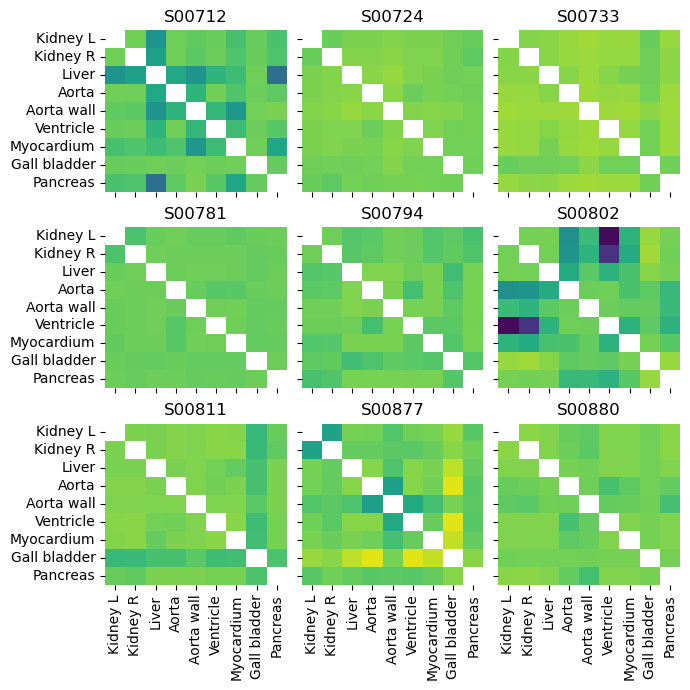

range = [-14, 4]


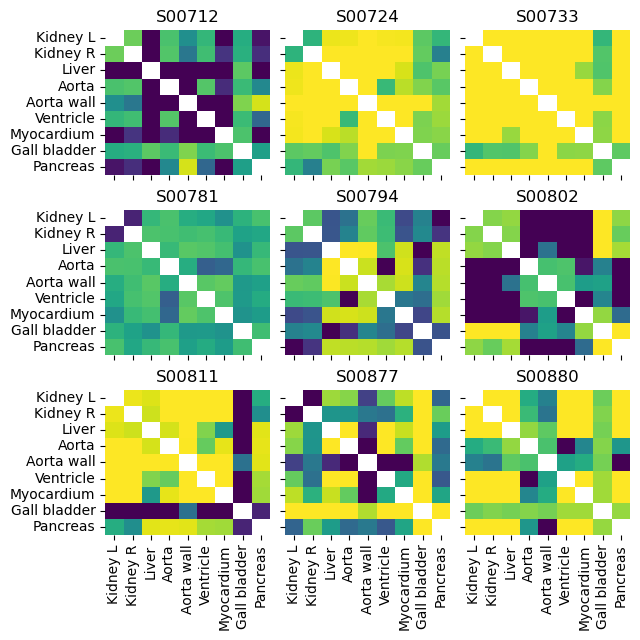

range = [-1.25, 0.5]


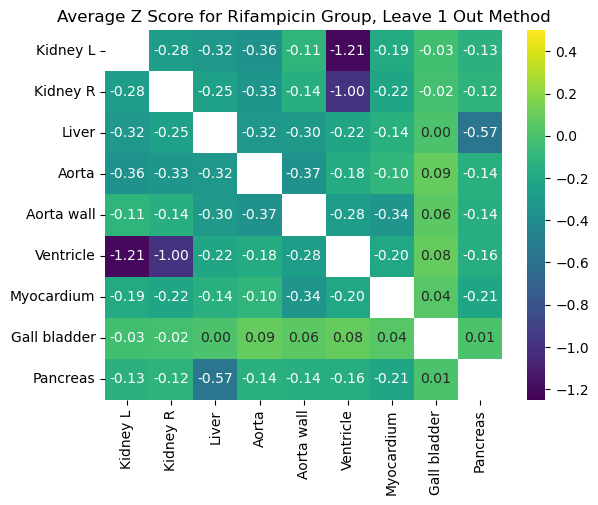

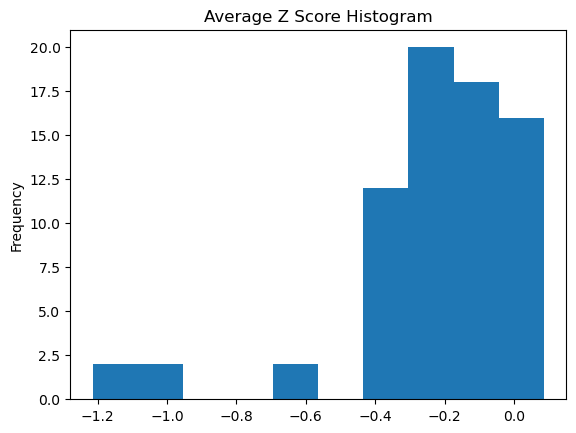

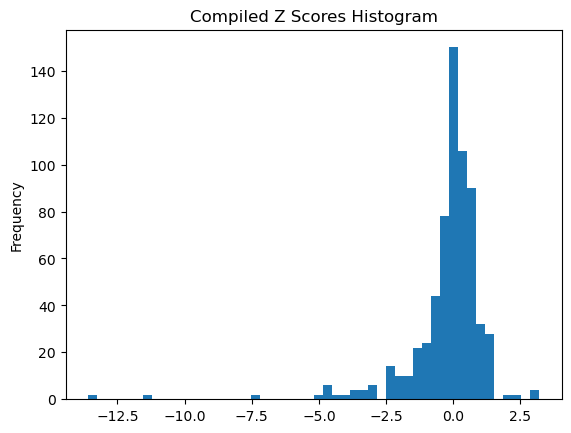

array([[<Axes: title={'center': 'Kidney L'}>,
        <Axes: title={'center': 'Kidney R'}>,
        <Axes: title={'center': 'Liver'}>],
       [<Axes: title={'center': 'Aorta'}>,
        <Axes: title={'center': 'Aorta wall'}>,
        <Axes: title={'center': 'Ventricle'}>],
       [<Axes: title={'center': 'Myocardium'}>,
        <Axes: title={'center': 'Gall bladder'}>,
        <Axes: title={'center': 'Pancreas'}>]], dtype=object)

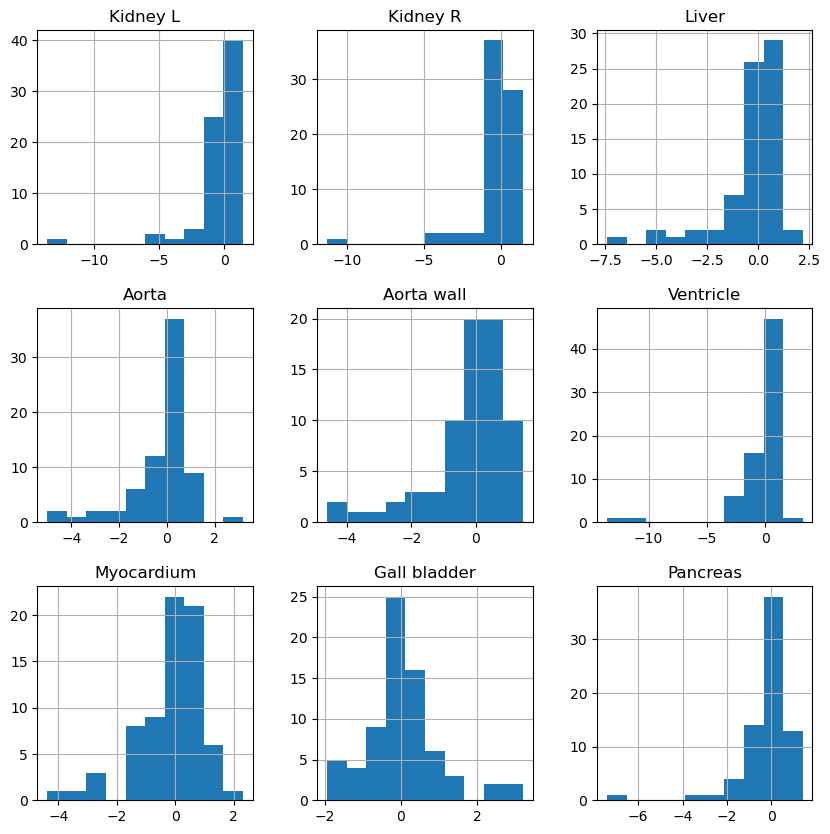

In [4]:
#Now the same but only the rifampicin subjects

fig, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(7,7))
zscore_list = []
i=0
for testsub in rifsubs:
    rifsubs_l1o = rifsubs.copy()
    rifsubs_l1o.remove(testsub)
    rif_l1o = df.transpose()[rifsubs_l1o].copy().transpose()
    refnet_l1o = rif_l1o.corr(method='pearson')
    refnet_l1o = refnet_l1o.transpose()
    ptb_l1o = df.transpose()[rifsubs_l1o].copy()
    ptb_l1o = ptb_l1o.assign(testsubdf=df.transpose()[testsub])
    ptbnet_l1o = ptb_l1o.transpose().corr(method='pearson').transpose()
    resnet_l1o = ptbnet_l1o-refnet_l1o
    # resnet_list.append(resnet_l1o)
    zscore_l1o = resnet_l1o/((1-refnet_l1o**2)/(len(rifsubs_l1o)-1))
    # Method to plot each individual z score map
    snszscore_indiv = sns.heatmap(zscore_l1o, vmin=-14, vmax=4, cmap=palette, cbar=False, fmt='0.1f', ax=axes.flat[i])
    axes.flat[i].set_title(testsub)
    zscore_list.append(zscore_l1o)
    i += 1
fig.tight_layout()
plt.show()
print('range = [-14, 4]')

#repeat with smaller range
fig, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(6.5,6.5))
zscore_list = []
i=0
for testsub in rifsubs:
    rifsubs_l1o = rifsubs.copy()
    rifsubs_l1o.remove(testsub)
    rif_l1o = df.transpose()[rifsubs_l1o].copy().transpose()
    refnet_l1o = rif_l1o.corr(method='pearson')
    refnet_l1o = refnet_l1o.transpose()
    ptb_l1o = df.transpose()[rifsubs_l1o].copy()
    ptb_l1o = ptb_l1o.assign(testsubdf=df.transpose()[testsub])
    ptbnet_l1o = ptb_l1o.transpose().corr(method='pearson').transpose()
    resnet_l1o = ptbnet_l1o-refnet_l1o
    # resnet_list.append(resnet_l1o)
    zscore_l1o = resnet_l1o/((1-refnet_l1o**2)/(len(rifsubs_l1o)-1))
    # Method to plot each individual z score map
    snszscore_indiv = sns.heatmap(zscore_l1o, vmin=-1.25, vmax=0.5, cmap=palette, cbar=False, fmt='0.1f', ax=axes.flat[i])
    axes.flat[i].set_title(testsub)
    zscore_list.append(zscore_l1o)
    i += 1
fig.tight_layout()
plt.show()
print('range = [-1.25, 0.5]')

avgzscore_l1o = sum(zscore_list)/len(zscore_list)
# print('min = ', avgzscore_l1o.stack().min(), ', max = ', avgzscore_l1o.stack().max())
snszscore_l1o = sns.heatmap(avgzscore_l1o, annot=True, vmin=-1.25, vmax=0.5, cmap=palette, fmt='0.2f')
plt.title('Average Z Score for Rifampicin Group, Leave 1 Out Method')
plt.show()
avgzscore_l1o.stack().plot.hist(bins=10)
plt.title('Average Z Score Histogram')
plt.show()
# fig, axis = plt.subplots(3, 3, figsize=(10,10))
# avgzscore_l1o.hist(ax=axis)
# plt.show()

zcomb_l1o = pd.concat(zscore_list, ignore_index=True)
zcomb_l1o.stack().plot.hist(bins=50)
plt.title('Compiled Z Scores Histogram')
plt.show()
fig, axis = plt.subplots(3, 3, figsize=(10,10))
zcomb_l1o.hist(ax=axis)

Z scores for each rifampicin subject compared to the control group


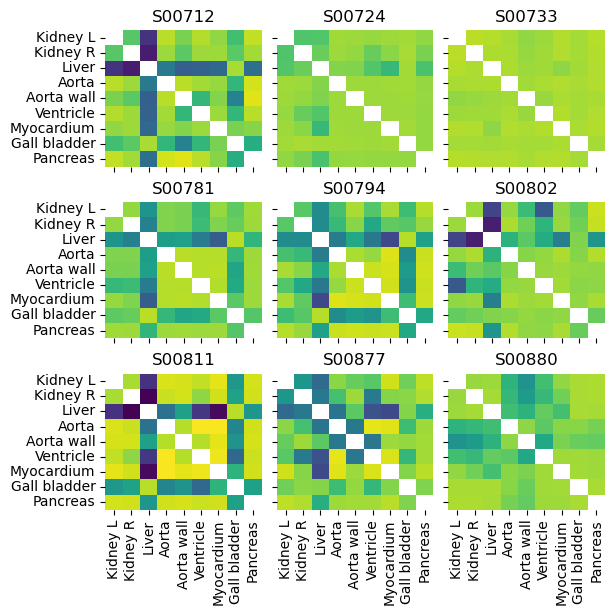

range = [-11,2] 



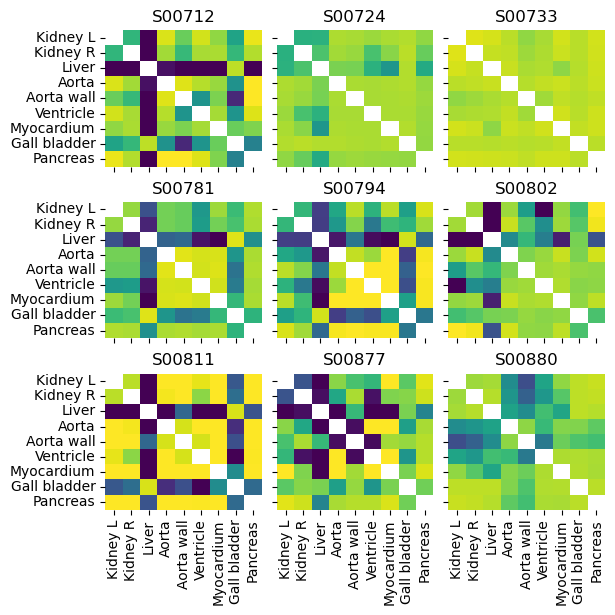

range = [-6,1] 



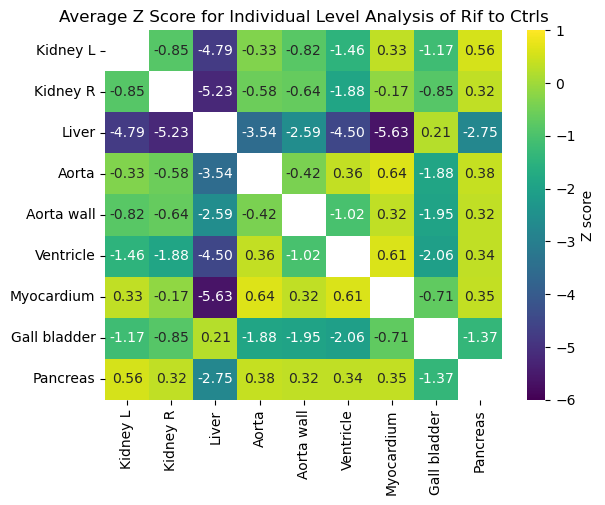

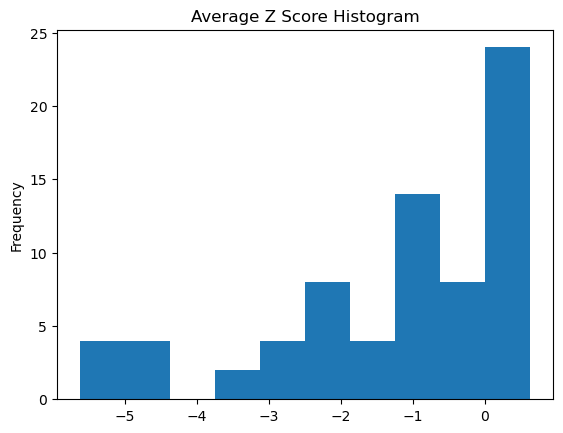

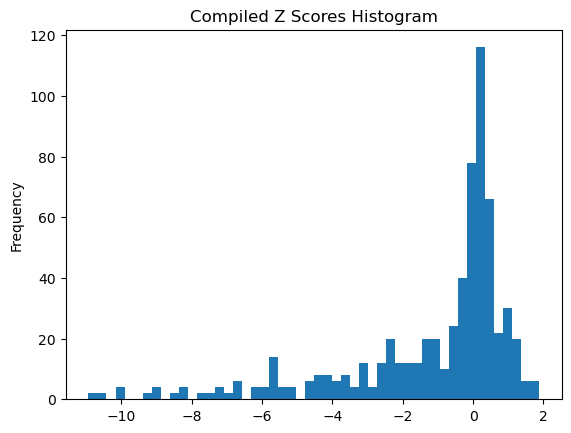

array([[<Axes: title={'center': 'Kidney L'}>,
        <Axes: title={'center': 'Kidney R'}>,
        <Axes: title={'center': 'Liver'}>],
       [<Axes: title={'center': 'Aorta'}>,
        <Axes: title={'center': 'Aorta wall'}>,
        <Axes: title={'center': 'Ventricle'}>],
       [<Axes: title={'center': 'Myocardium'}>,
        <Axes: title={'center': 'Gall bladder'}>,
        <Axes: title={'center': 'Pancreas'}>]], dtype=object)

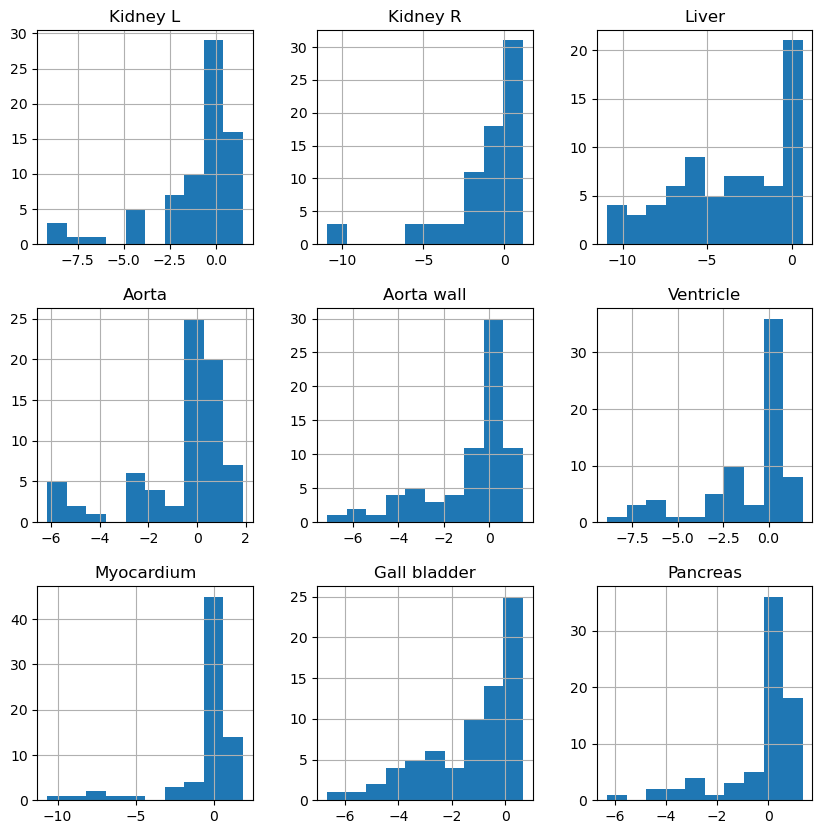

In [2]:
#Now the same but the rifampicin subjects into the control group (so, not leave one out approach but normal approach)
print('Z scores for each rifampicin subject compared to the control group')

ctrl = df.transpose()[ctrlsubs].copy().transpose()
refnet = ctrl.corr(method='pearson')
refnet = refnet.transpose()

fig, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(6.25,6.25))
i=0
zscore_list = []
for subject in rifsubs:
    ptb = df.transpose()[ctrlsubs].copy()
    ptb = ptb.assign(rifsub=df.transpose()[subject])
    ptbnet = ptb.transpose().corr(method='pearson').transpose()
    resnet = ptbnet-refnet
    zscore = resnet/((1-refnet**2)/(len(ctrlsubs)-1))
    # # Method to plot each individual z score map
    # snszscore_indiv = sns.heatmap(zscore, annot=True, vmin=-6, vmax=1, cmap=palette, fmt='0.2f')
    # plt.title("Z-score compared to controls for "+subject)
    # plt.show()
    # zscore_list.append(zscore)
    # Method to plot each individual z score map
    snszscore_indiv = sns.heatmap(zscore, vmin=-11, vmax=2, cmap=palette, cbar=False, fmt='0.1f', ax=axes.flat[i])
    axes.flat[i].set_title(subject)
    zscore_list.append(zscore)
    i += 1
fig.tight_layout()
plt.show()
print('range = [-11,2] \n')

#again with different colormap range
fig, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(6.25,6.25))
i=0
zscore_list = []
for subject in rifsubs:
    ptb = df.transpose()[ctrlsubs].copy()
    ptb = ptb.assign(rifsub=df.transpose()[subject])
    ptbnet = ptb.transpose().corr(method='pearson').transpose()
    resnet = ptbnet-refnet
    zscore = resnet/((1-refnet**2)/(len(ctrlsubs)-1))
    # # Method to plot each individual z score map
    # snszscore_indiv = sns.heatmap(zscore, annot=True, vmin=-6, vmax=1, cmap=palette, fmt='0.2f')
    # plt.title("Z-score compared to controls for "+subject)
    # plt.show()
    # zscore_list.append(zscore)
    # Method to plot each individual z score map
    snszscore_indiv = sns.heatmap(zscore, vmin=-6, vmax=1, cmap=palette, cbar=False, fmt='0.1f', ax=axes.flat[i])
    axes.flat[i].set_title(subject)
    zscore_list.append(zscore)
    i += 1
fig.tight_layout()
plt.show()
print('range = [-6,1] \n')

avgzscore = sum(zscore_list)/len(zscore_list)
# print('avg zscore min = ', avgzscore.stack().min(), ', max = ', avgzscore.stack().max())

snszscore = sns.heatmap(avgzscore, annot=True, vmin=-6, vmax=1, cmap=palette, cbar_kws={'label': 'Z score'}, fmt='0.2f')
plt.title('Average Z Score for Individual Level Analysis of Rif to Ctrls')
plt.show()
avgzscore.stack().plot.hist(bins=10)
plt.title('Average Z Score Histogram')
plt.show()

zcomb = pd.concat(zscore_list, ignore_index=True)
zcomb.stack().plot.hist(bins=50)
plt.title('Compiled Z Scores Histogram')
plt.show()
fig, axis = plt.subplots(3, 3, figsize=(10,10))
zcomb.hist(ax=axis)

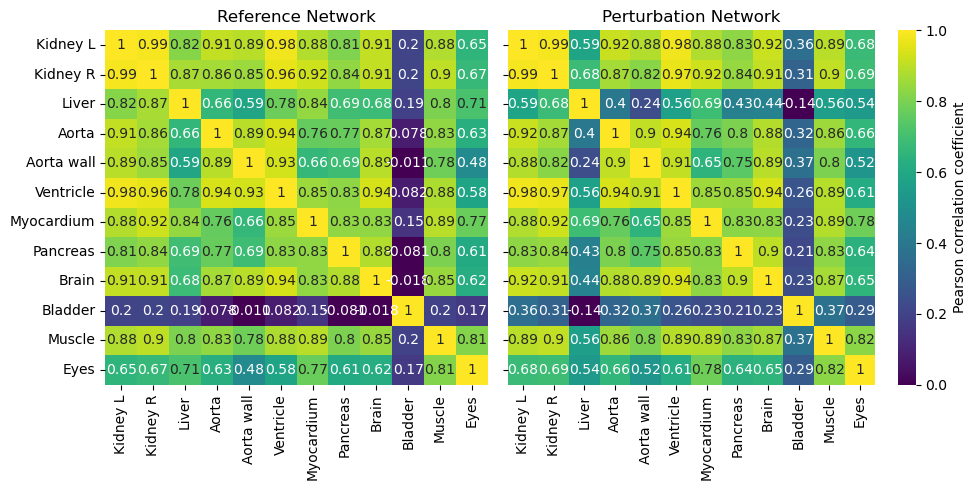

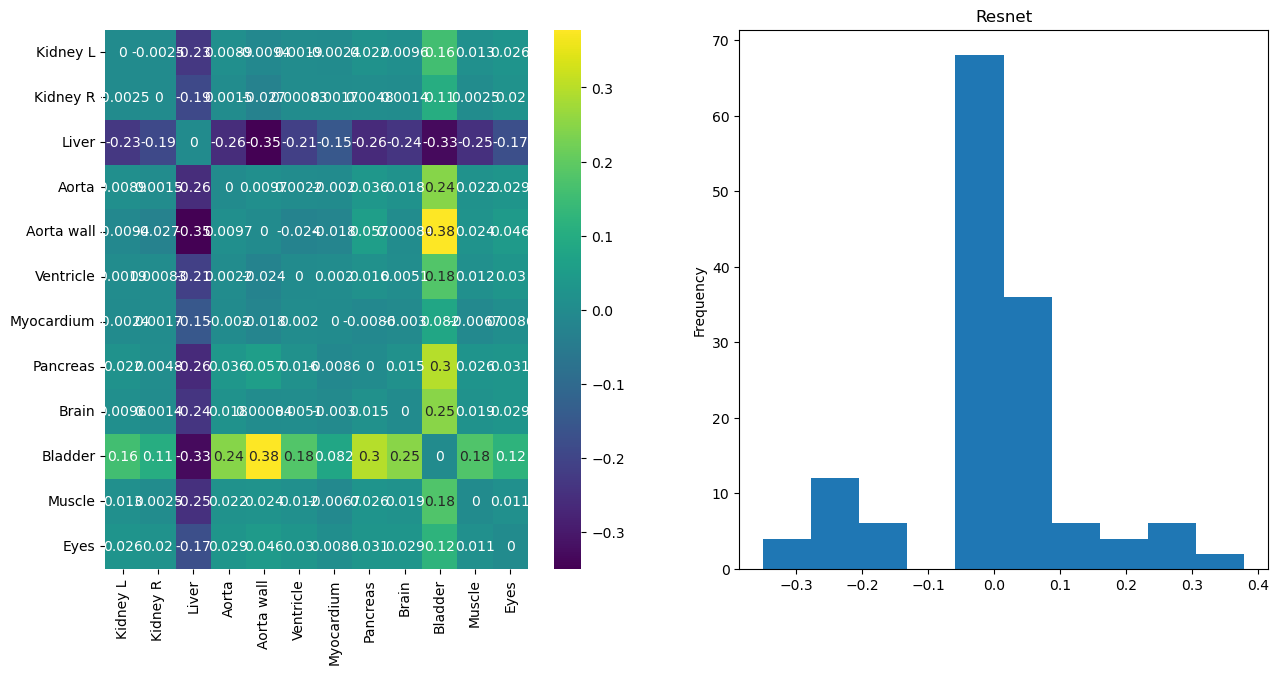

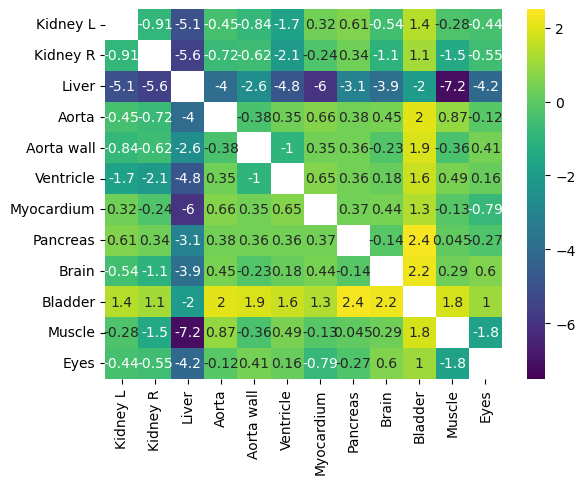

In [9]:
#use the late time data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from netgraph import Graph

#color palette choice for all graphing
palette='viridis'

#read in file, create dataframe with subjects on y, regions on x
filename = 'IPK_LI_LT_static.csv'
df = pd.read_csv(filename, sep=',', usecols=['Subject', 'Kidney L', 'Kidney R', 'Liver', 'Aorta', 'Aorta wall', 'Ventricle', 'Myocardium', 
                                        'Pancreas', 'Brain', 'Bladder', 'Muscle', 'Eyes'], index_col=['Subject'], header=0)
#df = df.transpose() swaps to subjects on x, regions on y

#get one dataframe of control subjects only
ctrlsubs = ['S00508', 'S00721', 'S00732', 'S00780', 'S00786', 'S00793', 'S00796', 'S00801', 'S00810', 'S00822', 'S00828', 'S00874', 'S00919', 'S00933',
                   'S00956']
rifsubs = ['S00712', 'S00724', 'S00733', 'S00781', 'S00794', 'S00802', 'S00811', 'S00877', 'S00880']
ctrl = df.transpose()[ctrlsubs].copy().transpose()

#create the refNET with PCC between each region pair, subjects are the x-axis and SUV for a given region is y-axis
#paper uses partial PCC with covariates of age and gender, i will just use PCC for now 
#(Identifying the individual metabolic abnormities from a systemic perspective using whole-body PET imaging by Tao Sun et al)
refnet = ctrl.corr(method='pearson')
refnet = refnet.transpose()

#create the plot with two subplots, setting figure size and gridspec ratio (figures end up diff sizes when cbar=false for one)
fig, ax = plt.subplots(ncols=2, figsize=(10,5),sharey=True, gridspec_kw={'width_ratios': [1, 1.2]})

#create the heatmap to represent the correlation network of the control subjects (refNET)
snsctrl = sns.heatmap(refnet, annot=True, vmax=1.0, vmin=0.0, cbar_kws={'label': 'Pearson correlation coefficient'}, cbar=False, ax=ax[0],
                     cmap=palette)
ax[0].set_title('Reference Network')

#create the perturbation network by adding one rif subject to the ctrl cohort refNET -> ptbNET
ptb = df.transpose()[ctrlsubs].copy()
ptb = ptb.assign(rifsub=df.transpose()[rifsubs[0]])
ptbnet = ptb.transpose().corr(method='pearson').transpose()

#create the heatmap that represents the ptbNET
snsptb = sns.heatmap(ptbnet, annot=True, vmax=1.0, vmin=0.0, cbar_kws={'label': 'Pearson correlation coefficient'}, ax=ax[1], 
                     cmap=palette)
ax[1].set_title('Perturbation Network')

#create the resNET=ptbNET-refNET
resnet = ptbnet-refnet
#set threshold of 30% to remove weak residual correlations arising after sub. arising possibly from noise
# thresh = 0.3*max(resnet.stack().where(resnet.stack()>0).max(), abs(resnet.stack().where(resnet.stack()<0).min()))
# print(thresh)
# for col in resnet.columns:
#     resnet.loc[((resnet[col]>0)&(resnet[col]<thresh)) | ((resnet[col]<0)&(resnet[col]>(-thresh))), col] = 0

#plot with minimal white space
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

snsres = sns.heatmap(resnet, annot=True, cmap=palette, ax=ax[0])

resnet.stack().plot.hist(ax=ax[1])
plt.title('Resnet')
plt.show()

#individual-level analysis
zscore_list = []
resnet_list = []
for subject in rifsubs:
    ptb = df.transpose()[ctrlsubs].copy()
    ptb = ptb.assign(rifsub=df.transpose()[subject])
    ptbnet = ptb.transpose().corr(method='pearson').transpose()
    resnet = ptbnet-refnet
    resnet_list.append(resnet)
    zscore = resnet/((1-refnet**2)/(len(ctrlsubs)-1))                #changing between this method and the one below shifts the z-score hist
    #zscore = (resnet-resnet.stack().mean())/resnet.stack().std()
    zscore_list.append(zscore)
avgzscore = sum(zscore_list)/len(zscore_list)
snszscore = sns.heatmap(avgzscore, annot=True, vmin=-7.5, vmax=2.5, cmap=palette)

In [98]:
#playing with thresholds
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from netgraph import Graph
from matplotlib.colors import BoundaryNorm, ListedColormap

#color palette choice for all graphing
palette='viridis'

my_colors = ['#440154FF', '#20A387FF', '#20A387FF', '#440154FF']
my_cmap = ListedColormap(my_colors)
bounds = [-1, -1/6, 1/6, 1]
my_norm = BoundaryNorm(bounds, ncolors=len(my_colors))

#read in file, create dataframe with subjects on y, regions on x
filename = 'IsotoPK_data_linearinterpolated_static.csv'
df = pd.read_csv(filename, sep=',', usecols=['Subject', 'Kidney L', 'Kidney R', 'Liver', 'Aorta', 'Aorta wall', 'Ventricle', 'Myocardium', 
                                      'Gall bladder', 'Pancreas'], index_col=['Subject'], header=0)
#df = df.transpose() swaps to subjects on x, regions on y

#get one dataframe of control subjects only
ctrlsubs = ['S00732', 'S00780', 'S00786', 'S00793', 'S00796', 'S00801', 'S00810', 'S00822', 'S00828', 'S00874', 'S00919', 'S00933',
                   'S00956']
rifsubs = ['S00712', 'S00724', 'S00733', 'S00781', 'S00794', 'S00802', 'S00811', 'S00877', 'S00880']
ctrl = df.transpose()[ctrlsubs].copy().transpose()

#create the refNET with PCC between each region pair, subjects are the x-axis and SUV for a given region is y-axis
#paper uses partial PCC with covariates of age and gender, i will just use PCC for now 
#(Identifying the individual metabolic abnormities from a systemic perspective using whole-body PET imaging by Tao Sun et al)
refnet = ctrl.corr(method='pearson')
refnet = refnet.transpose()

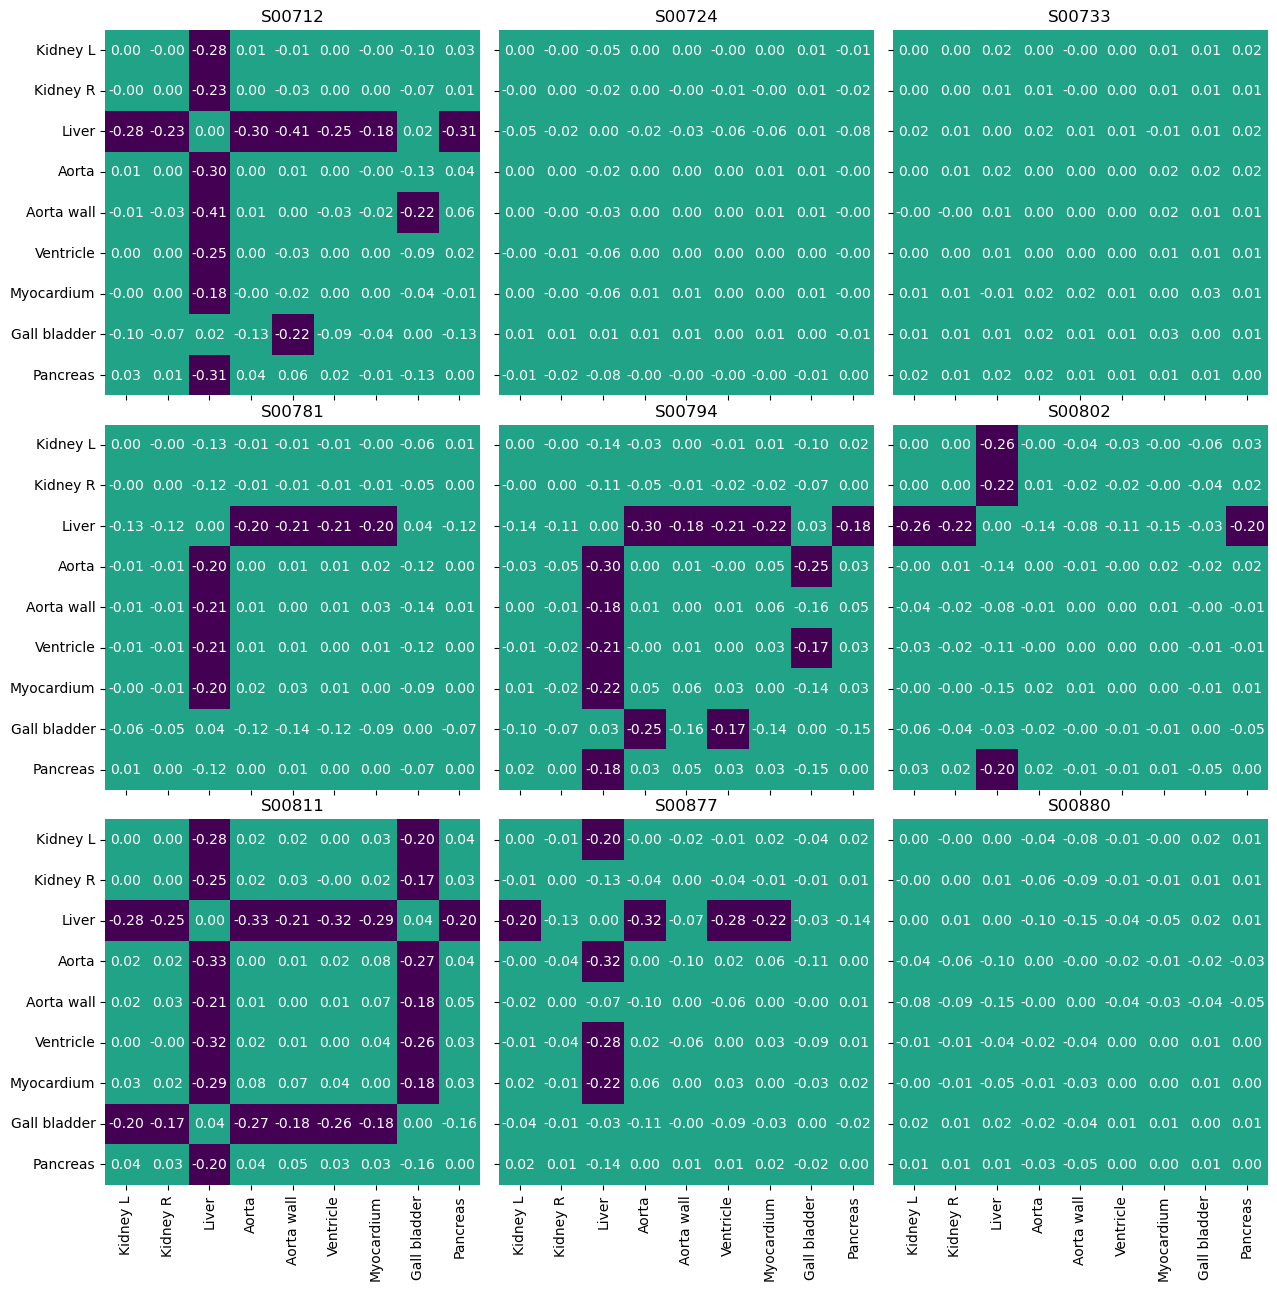

In [99]:
fig, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(15,15), gridspec_kw = {'wspace':0.05, 'hspace':0.08})
i=0

#individual-level analysis
zscore_list = []
resnet_list = []
for subject in rifsubs:
    ptb = df.transpose()[ctrlsubs].copy()
    ptb = ptb.assign(rifsub=df.transpose()[subject])
    ptbnet = ptb.transpose().corr(method='pearson').transpose()
    resnet = ptbnet-refnet
    # for col in resnet:
    #     resnet.loc[abs(resnet[col]) < (1/6), col] = 0
    # fig, ax = plt.subplots(ncols=2, figsize=(14,5),sharey=True, gridspec_kw={'width_ratios': [1, 1.2]})
    # snsresnet1 = sns.heatmap(resnet, annot=True, fmt='0.3f', vmin=-0.5, vmax=0.5, cmap=palette, linecolor="k", linewidths=0.003, ax=ax[0], cbar=False)
    # resnet_list.append(resnet)
    # mask = abs(resnet) < (1/6)
    # snsresnet2 = sns.heatmap(resnet, annot=True, fmt='0.3f', vmin=-0.5, vmax=0.5, cmap=palette, mask=mask, linecolor="k", linewidths=0.003, ax=ax[1])
    zscore = resnet/((1-refnet**2)/(len(ctrlsubs)-1))                #changing between this method and the one below shifts the z-score hist
    #zscore = (resnet-resnet.stack().mean())/resnet.stack().std()
    zscore_list.append(zscore)
    snsresnet_grid = sns.heatmap(resnet, annot=True, vmin=-1/6, vmax=1/6, cmap=my_cmap, norm=my_norm, cbar=False, fmt='0.2f', ax=axes.flat[i])
    axes.flat[i].set_title(subject)
    i+=1
# avgresnet = sum(resnet_list)/len(resnet_list)
# avgzscore = sum(zscore_list)/len(zscore_list)
# snszscore = sns.heatmap(avgzscore, annot=True, vmin=-2, vmax=1, cmap=palette)
# ax[1].set_title('Z score network, significance thresholded')
# plt.show()

plt.savefig('d_PCC_allsubs.pdf', format='pdf', bbox_inches='tight')
# plt.show()

# mask = abs(avgresnet) < (1/6)
# snsresnet = sns.heatmap(avgresnet, annot=True, vmin=-0.1, vmax=0.1, cmap=palette, mask=mask)